In [1]:
import pandas as pd
from xbbg import blp
from datetime import datetime

### Tickers

Choose callable bond.
* For European exercise, consider banks
* Freddie Mac has Bermudan exercise, but some have first call date years in future, which makes approximately European.

Find a similar bond with maturity equal to first call date.
* Find second Freddie that is far out of the money, such that callable aspect has little value.

In [2]:
tickers = [    
    # 'FHLMC 4.41 01/28/30 Govt',
    # 'FHLMC 0.97 01/28/28 Govt',
    # 'FHLMC 1.25 01/29/30 Govt',

    'FHLMC 4.55 02/11/28 Govt',
    'FNMA 5 01/28/30 Govt',
]

start_date = '2025-02-01'
end_date = '2025-02-18'

In [3]:
FLDS_PROPERTIES = [
    'SECURITY_DES',
    'ID_CUSIP',
    'ISSUER',
    'MTY_TYP',
    'ISSUER_INDUSTRY',
    'AMT_ISSUED',
    'CPN',
    'CPN_FREQ',    
    'LAST_UPDATE_DT',
    'ISSUE_DT',
    'MATURITY',
    'FIRST_CALL_DT_ISSUANCE',
    'NXT_CALL_DT',
    'NXT_CALL_PX',
]

df_props = blp.bdp(tickers, flds=FLDS_PROPERTIES)
df_props['cpn'] /= 100

In [4]:
df_props = df_props.rename(columns=
                {'security_des':'Security',
                 'id_cusip':'CUSIP',
                 'amt_issued':'Amount Issued',
                 'issue_dt':'Date Issued',
                 'maturity':'Date Matures',
                 'nxt_call_dt':'Date Next Call',
                 'first_call_dt_issuance':'Date of First Possible Call',
                 'last_update_dt':'Date Quoted',
                 'issuer_industry':'Issuer Industry',
                 'issuer':'Issuer',
                 'cpn':'Cpn Rate',
                 'cpn_freq':'Cpn Freq',
                 'nxt_call_px':'Strike',
                 'mty_typ':'Maturity Type',                
                 }).set_index('Security').T

df_props.index.name = 'info'

In [5]:
df_props.style.format('{:.2%}',subset=pd.IndexSlice[["Cpn Rate"], :]).format('{:,.0f}',subset=pd.IndexSlice[["Amount Issued"], :])

Security,FHLMC 4.55 02/11/28
info,
CUSIP,3134HA6A6
Issuer,FREDDIE MAC
Maturity Type,CALLABLE
Issuer Industry,GOVT AGENCY
Amount Issued,"1,000,000,000"
Cpn Rate,4.55%
Cpn Freq,2
Date Quoted,2025-02-18
Date Issued,2025-02-11


In [6]:
FLDS_CALCS = [
    'SECURITY_DES',
    'LAST_UPDATE_DT',
    'MTY_YEARS_TDY',
    'PX_CLEAN_MID',
    'PX_DIRTY_MID',
    'INT_ACC',
    'YLD_YTC_MID',
    'YLD_YTM_MID',
    'DUR_MID',
    'DUR_ADJ_MID',
    'CNVX_MID',
    'YAS_YLD_SPREAD',
    'YAS_OAS_SPRD',
    'YAS_OAS_VOL',
]

df_calcs = blp.bdp(tickers, flds=FLDS_CALCS, OAS_CURVE_ID='IRS')

df_calcs = df_calcs.rename(columns={
    'security_des':'Security',
    'last_update_dt':'Date Quoted',
    'yas_yld_spread':'Treasury YLD Spread',
    'yas_oas_sprd':'OAS Spread',
    'int_acc':'Accrued Interest',
    'px_clean_mid':'Clean Price',
    'px_dirty_mid':'Dirty Price',
    'cnvx_mid':'Convexity',
    'dur_mid':'Duration',
    'dur_adj_mid':'Modified Duration',
    'yld_ytc_mid':'YTM Call',
    'yld_ytm_mid':'YTM Maturity',
    'yas_oas_vol':'Implied Vol',
    'mty_years_tdy':'TTM'
    }).set_index('Security').T

df_calcs.index.name = 'quotes'

In [7]:
df_calcs.style.format('{:.2f}', subset=pd.IndexSlice[df_calcs.index[1:], :])

Security,FHLMC 4.55 02/11/28
quotes,
Date Quoted,2025-02-18
TTM,2.98
Clean Price,99.72
Dirty Price,99.83
Accrued Interest,0.11
YTM Call,4.85
YTM Maturity,4.65
Duration,2.81
Modified Duration,2.75


In [8]:
FLDS_HIST = [
    'PX_CLEAN_MID',
    'PX_DIRTY_MID',
    'OAS_SPREAD_MID',
]

df_hist = blp.bdh(tickers, flds=FLDS_HIST, start_date=start_date, end_date=end_date)

df_hist.rename(columns={
    'PX_CLEAN_MID':'Clean Price',
    'PX_DIRTY_MID':'Dirty Price',
},inplace=True)


In [9]:
clean = df_hist.xs('Clean Price', level=1, axis=1)
dirty = df_hist.xs('Dirty Price', level=1, axis=1)
clean.index.name = 'date'
dirty.index.name = 'date'

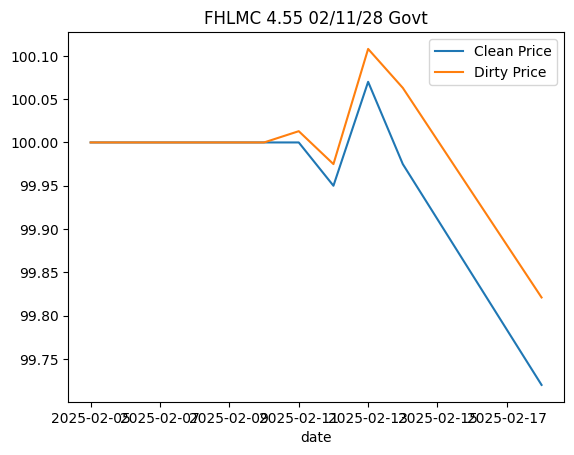

In [10]:
col = df_hist.columns.levels[0][0]
df_hist[col].plot(title=col);

In [11]:
# col = df_hist.columns.levels[0][1]
# df_hist[col].plot(title=col);

***

### Save Data

In [12]:
DATE = df_props.loc['Date Quoted'].iloc[0].strftime("%Y-%m-%d")
OUTFILE = f'../data/callable_bonds_{DATE}'

In [13]:
outfile = f'../data/{OUTFILE}.xlsx'
with pd.ExcelWriter(outfile) as writer:  
    df_props.to_excel(writer, sheet_name= 'info', index=True, )
    df_calcs.to_excel(writer, sheet_name= 'quotes', index=True)
    #clean.to_excel(writer, sheet_name= 'clean prices', index=True)
    #dirty.to_excel(writer, sheet_name= 'dirty prices', index=True)

***